In [2]:
# 1. Initial settings
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import time,os
import xarray as xr
import pickle
from scipy import stats
plt.rcParams.update({'font.size': 16})
################################
# import oggm and Get the default params
from oggm import cfg, utils, workflow, tasks, graphics
import oggm.cfg as cfg
cfg.initialize(logging_level='WORKFLOW')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False
from oggm.core.massbalance import ScalarMassBalance
from oggm.core import massbalance
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb, mb_calibration_from_wgms_mb
from oggm.tests.funcs import bu_tidewater_bed
from oggm.core.massbalance import MultipleFlowlineMassBalance, MonthlyTIModel
from oggm.core.flowline import FluxBasedModel,fa_sermeq_speed_law, k_calving_law
################################
# import the Graphics
import Graphics_RT
from Graphics_RT import plot_modeloutput_section_New
################################
#setting the workplace
rgi_id = 'RGI60-01.10689'
Figpath='/home/ruitang/OGGM-Ruitang/Results/Test/'+rgi_id
Figpath_Folder_all=utils.mkdir(Figpath,reset=True)

# figure
Figpath_Folder_tif_path=Figpath+'/Tif/'
Figpath_Folder_png_path=Figpath+'/Png/'
Figpath_Folder_tif=utils.mkdir(Figpath_Folder_tif_path,reset=True)
Figpath_Folder_png=utils.mkdir(Figpath_Folder_png_path,reset=True)
# data
Figpath_Folder_data_path=Figpath+'/Data/'
Figpath_Folder_data=utils.mkdir(Figpath_Folder_data_path,reset=True)
file_txt_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.txt'
with open(file_txt_path_name,"w") as file:
    file.write("************* Here is the model results for glacier {}************* \n".format(rgi_id))
file_data_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.pickle'

/home/ruitang/OGGM-Ruitang/oggm_Ruitang/oggm/cfg.py:373: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2023-10-18 16:45:54: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-10-18 16:45:54: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-10-18 16:45:54: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-10-18 16:45:55: oggm.cfg: PARAMS['cfl_n

2023-10-18 16:45:55: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2023-10-18 16:45:55: oggm.cfg: Multiprocessing switched ON after user settings.
2023-10-18 16:45:56: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-10-18 16:45:56: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


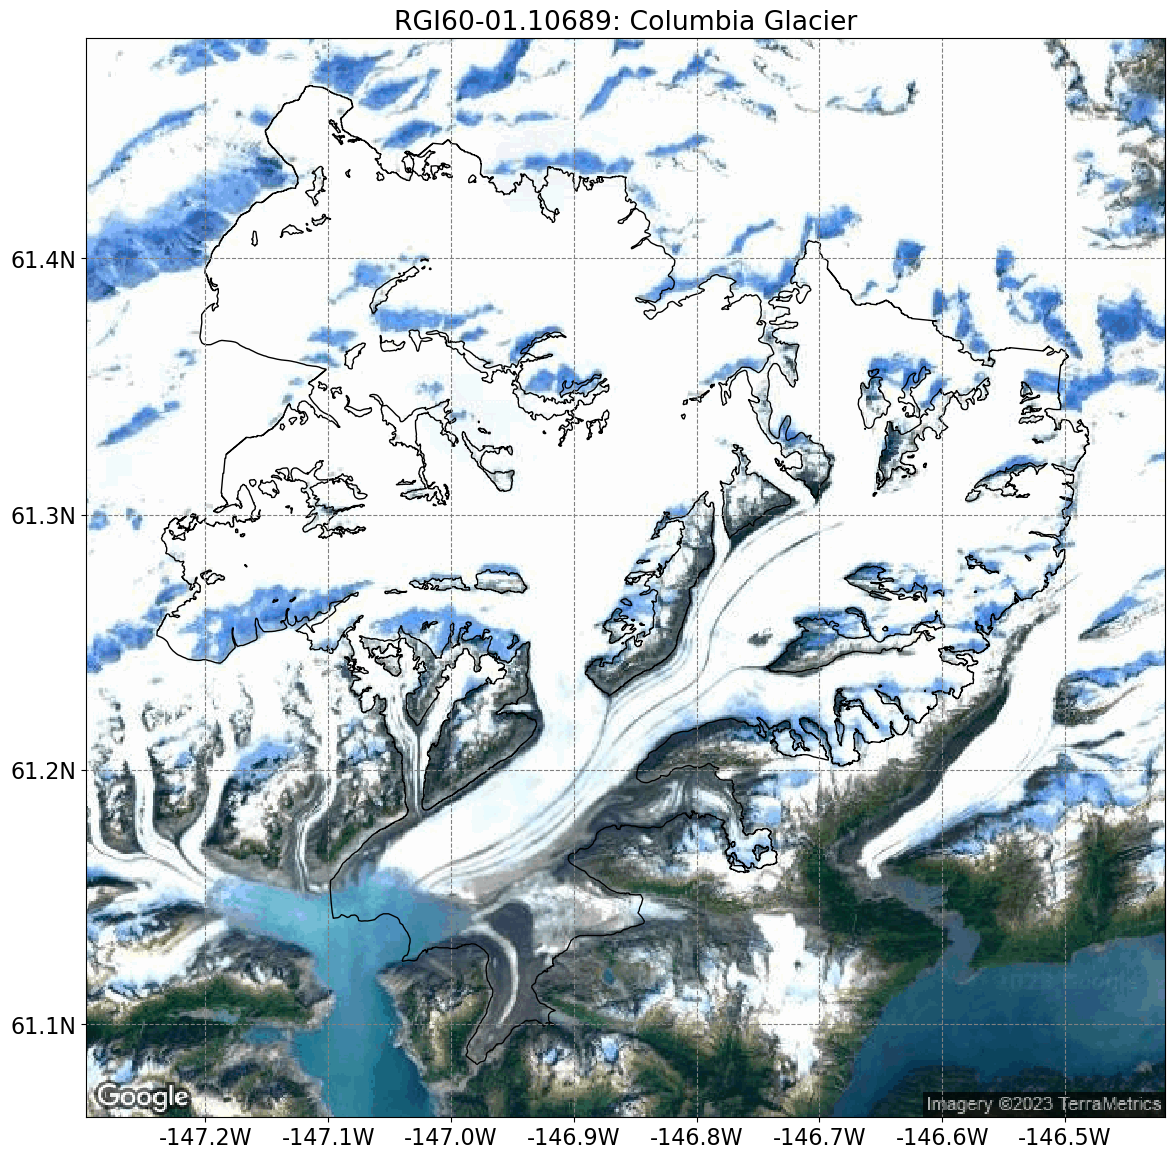

In [3]:
# download the glacier inventory dataset
 # Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] =Figpath
cfg.PARAMS['store_model_geometry'] = True
# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True
# Download from the "OGGM shop"
# Go - get the pre-processed glacier directories
# You have to explicitly indicate the url from where you want to start from
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/'
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
gdir_woc = workflow.init_glacier_directories([rgi_id], from_prepro_level=3, prepro_base_url=base_url, prepro_border=80)[0]
tasks.init_present_time_glacier(gdir_woc)
graphics.plot_googlemap(gdir_woc, figsize=(12,12));

In [4]:
# Calving params - default used to be 2.4, we changed it to 0.6
# cfg.PARAMS['inversion_calving_k'] = 0.6
# cfg.PARAMS['calving_k'] = 0.6
cp_dir = os.path.join(cfg.PATHS['working_dir'], 'calving')
utils.mkdir(cp_dir, reset=True)
gdir_wc = utils.copy_to_basedir(gdir_woc, base_dir=cp_dir, setup='all')
# # Find out the calving values
# out_calving = tasks.find_inversion_calving_from_any_mb(gdir_wc)
# # Get ready
# tasks.init_present_time_glacier(gdir_wc)
# # print output
# out_calving

In [5]:
# Calving params - default used to be 2.4, we changed it to 0.6
# cfg.PARAMS['inversion_calving_k'] = 0.6
# cfg.PARAMS['calving_k'] = 0.6
cfg.PARAMS['flowline_dx']=1
cfg.PARAMS['evolution_model'] = 'FluxBased'
# These are switched off per default
cfg.PARAMS['use_kcalving_for_inversion'] = True
#cfg.PARAMS['use_kcalving_for_run'] = True
cfg.PARAMS['check_calib_params'] = True
cp_dir = os.path.join(cfg.PATHS['working_dir'], 'calving')
utils.mkdir(cp_dir, reset=True)
gdir_wc = utils.copy_to_basedir(gdir_woc, base_dir=cp_dir, setup='all')
# Get ready
out_calving = tasks.find_inversion_calving_from_any_mb(gdir_wc)
#cfg.PARAMS['downstream_line_shape']='parabola'
tasks.init_present_time_glacier(gdir_wc)
out_calving

2023-10-18 16:46:01: oggm.cfg: PARAMS['flowline_dx'] changed from `2.0` to `1`.
2023-10-18 16:46:01: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2023-10-18 16:46:01: oggm.cfg: PARAMS['use_kcalving_for_inversion'] changed from `False` to `True`.
2023-10-18 16:46:01: oggm.cfg: WARNING: adding an unknown parameter `check_calib_params`:`True` to PARAMS.


{'calving_flux': 1.9214022719267183,
 'calving_rate_myr': 694.7002995985208,
 'calving_law_flux': 1.9214022719267172,
 'calving_water_level': -9.995796528206418,
 'calving_inversion_k': 0.6,
 'calving_front_slope': 0.026179938779914945,
 'calving_front_water_depth': 1157.8338326642008,
 'calving_front_free_board': 10.0,
 'calving_front_thick': 1167.8338326642008,
 'calving_front_width': 2368.3166101987167}

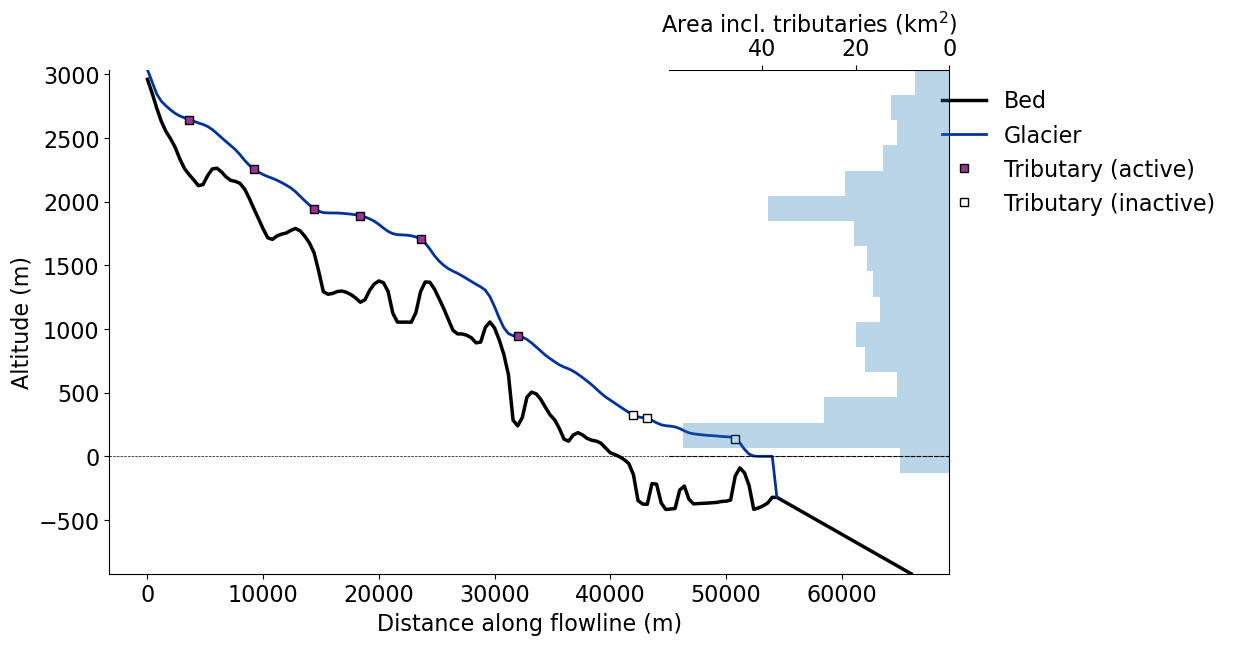

In [6]:
# get the glacier profile along the flowline(main centerline) and area histogram
bu_fl = gdir_woc.read_pickle('model_flowlines')[-1]
# graphics.plot_modeloutput_section([bu_fl])
Graphics_RT.plot_modeloutput_section_New([bu_fl])
# ax=plt.gca()
# ax.set_ylim(-2000,3000)
plt.axhline(y=0,linestyle='--',color='k',linewidth=0.8)
#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile_AreaHist'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile_AreaHist'+'.png',dpi=600,bbox_inches='tight')

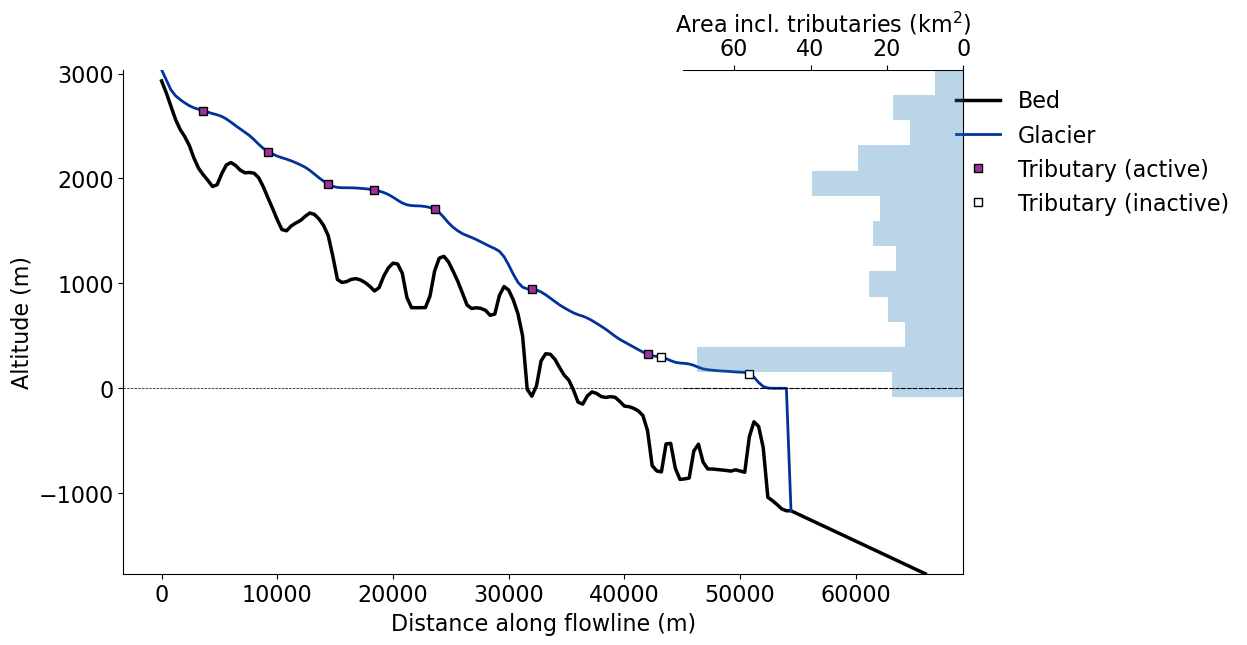

In [9]:
# get the glacier profile along the flowline(main centerline) and area histogram
fl = gdir_wc.read_pickle('model_flowlines')[-1]
# graphics.plot_modeloutput_section([bu_fl])
Graphics_RT.plot_modeloutput_section_New([fl])
# ax=plt.gca()
# ax.set_ylim(-2000,3000)
plt.axhline(y=0,linestyle='--',color='k',linewidth=0.8)
#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_profile_AreaHist'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_profile_AreaHist'+'.png',dpi=600,bbox_inches='tight')

In [8]:
bu_fl.flux*5

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [ ]:
dir(bu_fl)

In [ ]:
fls=gdir_wc.read_pickle('model_flowlines')
# graphics.plot_modeloutput_section([fls[-1]])
# fig = plt.figure(figsize=(12, 6))
# ax = fig.add_axes([0.07, 0.08, 0.7, 0.84])
# ax.set_ylim(-2000,3000)
# ax=plt.gca()
Graphics_RT.plot_modeloutput_section_New([fls[-1]])
plt.axhline(y=0,linestyle='--',color='k',linewidth=0.8)
# plt.ylim(-2000,3000)

In [ ]:
dir(bu_fl)

In [ ]:
# check the difference before inversion and after inversion

Diff_sur_H=bu_fl.surface_h[:-10]-fls[-1].surface_h


In [ ]:
type(Diff_sur_H)

In [ ]:
plt.plot(Diff_sur_H)

# Diff_sur_H.plot()

In [ ]:
len(Diff_sur_H)

In [ ]:
Diff_sur_H

In [ ]:

cfg.PARAMS['use_kcalving_for_run'] = False
model_woc = tasks.run_constant_climate(gdir_woc, y0=2000, nyears=100,calving_law=k_calving_law)
cfg.PARAMS['use_kcalving_for_run'] = True
model_wc = tasks.run_constant_climate(gdir_wc, y0=2000, nyears=100,calving_law=k_calving_law)
df_diag = model_woc.get_diagnostics()
df_tmp = model_wc.get_diagnostics()
df_diag['Bed (with calving)'] = df_tmp['bed_h']
df_diag['Bed (without calving)'] = df_diag['bed_h']
df_diag['Surface yr 0'] = gdir_woc.read_pickle('model_flowlines')[-1].surface_h
df_diag['Surface yr 100 (with calving)'] = df_tmp['surface_h']
df_diag['Surface yr 100 (without calving)'] = df_diag['surface_h']
df_diag.index = df_tmp.index.values / 1000
df_diag.index.name = 'Distance along flowline [km]'
df_diag = df_diag.loc[df_diag['Surface yr 0'] > df_diag['Bed (without calving)']]
f, ax = plt.subplots(1, 1, figsize=(12, 5))
var = ['Surface yr 100 (with calving)', 'Bed (with calving)', 'Surface yr 100 (without calving)', 'Bed (without calving)']
df_diag[var].plot(ax=ax, style=['-', '--', '-', ':'], color=['C2', 'k', 'C3', 'k']);
plt.hlines(0, 0, df_diag.index[-1], color='C0', linestyle=':');

In [ ]:
# fls=gdir_wc.read_pickle('model_flowlines')
cfg.PARAMS['use_kcalving_for_run'] = True
mbmod_fl = massbalance.MultipleFlowlineMassBalance(gdir_wc,fls=fls,use_inversion_flowlines=True,mb_model_class=MonthlyTIModel)

# model_wc=tasks.run_from_climate_data(gdir_wc, mb_model=mbmod_fl, store_fl_diagnostics=True,mb_elev_feedback='monthly',store_monthly_step='True');
tasks.run_with_hydro(gdir_wc,run_task=tasks.run_from_climate_data,store_monthly_hydro=True,mb_model=mbmod_fl, store_fl_diagnostics=True)
# ys=2010,ye=2019,
# here get the flowline diagnostic information
f = gdir_wc.get_filepath('fl_diagnostics')
with xr.open_dataset(f) as ds:
    fl_ids = ds.flowlines.data
with xr.open_dataset(f, group=f'fl_{fl_ids[-1]}') as ds:
    ds_fl_diag = ds.isel(time=slice(0, -1)).load()

print(cfg.PARAMS['inversion_calving_k'])